# Important Libraries For The Assignment


In [5]:
import cv2
import os
import glob
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# A.The dataset has 10 images per 40 subjects. Every image is a grayscale image of  size 92x112.(10 Points) 
 


In [7]:
img_dir = "./ATT"  # Enter Directory of all images
data_path = os.path.join(img_dir, '*g')
files = glob.glob(data_path)
data = []
i=0
for f1 in files:
    i=i+1
    img = cv2.imread(f1)
    dim=(92,112)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    data.append(gray)
    mydata = np.array(data)
    # print("Image : \n",mydata)
##fixing shape->400*10304
d=np.reshape(mydata, (400, 10304))
print("Shape od D matrix :",d.shape)

NameError: name 'mydata' is not defined

# Preparing the Labels Of the Data Stack the 400 vector into a single Data Matrix D and generate the label vector y.The labels are integers from 1:40 corresponding to the subject id.

In [7]:
labels = []
personN=1
for i in range(1,401):

    person= str(personN)
    labels.append(person)
    z=i%10
    if z<1:
        personN = personN +1


data = pd.DataFrame(data=d)
data['labels'] = labels
X = data.drop('labels',axis = 1)

50% - %50 Splitting

In [8]:

i_train=0
i_test=0
train_split_value = int(d.shape[0]*(5/10))
test_split_value = d.shape[0] - train_split_value
    
X_train = np.zeros((train_split_value,10304))
y_train = np.zeros((train_split_value,1)) 
    
X_test = np.zeros((test_split_value,10304))
y_test = np.zeros((test_split_value,1))

for i in range(400):
    if i%2==0:
        X_test[i_test,:] = X.iloc[i]
        y_test[i_test] = labels[i]
        i_test+=1
        #odd
    
    else:
        X_train[i_train,:] = X.iloc[i]
        y_train[i_train] = labels[i]
        i_train+=1
        

train_data = pd.DataFrame(data = X_train)
train_data['labels'] = y_train

test_data = pd.DataFrame(data = X_test)
test_data['labels'] = y_test



data = train_data

70% - 30% Splitting

In [ ]:
#splitting the data
X = data.drop('labels',axis = 1)

i_train=0
i_test=0
train_split_value = int(d.shape[0]*(7/10))
test_split_value = d.shape[0] - train_split_value
    
X_train = np.zeros((train_split_value,10304))
y_train = np.zeros((train_split_value,1)) 
    
X_test = np.zeros((test_split_value,10304))
y_test = np.zeros((test_split_value,1))

counter = 0 
for i in range(400):
    if i % 3 == 0 and i != 0:
        if counter < 3*(i/10): 
            X_test[i_test,:] = X.iloc[i]
            y_test[i_test] = labels[i]
            i_test+=1
            counter +=1
        
    else:
        X_train[i_train,:] = X.iloc[i]
        y_train[i_train] = labels[i]
        i_train+=1
        
train_data = pd.DataFrame(data = X_train)
train_data['labels'] = y_train

test_data = pd.DataFrame(data = X_test)
test_data['labels'] = y_test

print('test ',test_data.shape,'train: ',train_data.shape)

# LDA Implementation

In [9]:
mu_all = [np.mean(data[col]) for col in data.columns[:-1]]
from numpy import linalg as LA 
labels = data.labels.unique()
mu= []  
l =0
#means
for i in labels:
    means=[]
    for col in data.columns[:-1]:
        means.append(np.mean(data[data['labels'] == i][col]))
    mu.append(means)
print('mus',len(mu),len(mu[0]))

# b 
i =0
b = np.zeros((10304,10304))

for i in range(40):
    mat_diff = np.reshape(np.subtract(mu[i],mu_all),(10304,1))
    b = np.add(b,5*np.matmul(mat_diff,np.transpose(mat_diff)))
print('shape of b',b.shape)
# print(np.transpose(matt_diff).shape)

#z[i]
z = []
for i in range(40):

    d = data[data['labels'] == labels[i]]
    d = d.drop('labels',axis=1)

    class_mean = np.reshape(mu[i],(10304,1))
    mean_by_ones_transpose =np.matmul(np.ones((5,1)),np.transpose(class_mean))
    z.append(np.subtract(d,mean_by_ones_transpose))

#s[i] and S
S = np.zeros((10304,10304))
for i in range(40):
    mat = np.array(z[i])
    output = np.matmul(np.transpose(mat),mat)
    S = np.add(S,output)
print('shape of S',S.shape)


#eigen values and vectors && choosing best 39 vector
E_Values_LDA , E_Vectors_LDA  = LA.eigh(np.matmul(LA.inv(S),b))
idx = E_Values_LDA.argsort()[::-1]##
E_Values_Sorted = E_Values_LDA[idx]
E_Vectors_Sorted = E_Vectors_LDA[:,idx]
projMatrix = E_Vectors_Sorted[:,:39]  # first 39 columns 
print(projMatrix.shape)

mus 40 10304
shape of b (10304, 10304)
shape of S (10304, 10304)
(10304, 39)


In [10]:
U_Train_LDA_projection = train_data.drop('labels',axis=1).dot(projMatrix)
U_Test_LDA_projection = test_data.drop('labels',axis=1).dot(projMatrix)

print('U_Train_LDA_projection',U_Train_LDA_projection.shape)
print('U_Test_LDA_projection',U_Test_LDA_projection.shape)

U_Train_LDA_projection (200, 39)
U_Test_LDA_projection (200, 39)


In [11]:
def Knn(train_data,train_label,test_data,test_label,alpha,best_n):
      
    score = []
    for i,neighbour in zip(range(len(best_n )),best_n ):
        KnnTest = KNeighborsClassifier(n_neighbors = neighbour, weights = 'distance') 
        KnnTest.fit(train_data.T, train_label) 
        pred = KnnTest.predict(test_data.T)
        score.append(accuracy_score(pred,test_label)) 
        print(score)
        
    plt.plot(score,best_n)
    plt.xlabel('Accuracy')
    plt.ylabel('KNN')
    plt.show()
    
    
    plt.plot(alpha,score)
    plt.xlabel('Accuracy')
    plt.ylabel('ALpha')
    plt.show()


(200, 39)
(200, 1)
(200, 39)
(200, 1)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


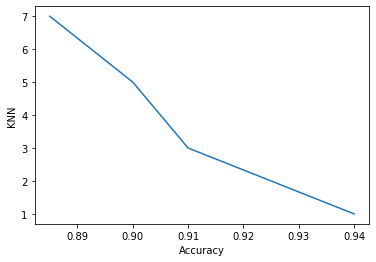

In [12]:
def Knn(train_data,train_label,test_data,test_label):
    best_n  = [1,3,5,7]
    score = []
    
    train_label = np.reshape(np.array(train_label),(200,1))
    test_label = np.reshape(np.array(test_label),(200,1))
    print(train_data.shape)
    print(train_label.shape)
    print(test_data.shape)
    print(test_label.shape)
    
    for i,neighbour in zip(range(len(best_n )),best_n ):
        KnnTest = KNeighborsClassifier(n_neighbors = neighbour, weights = 'distance') 
        KnnTest.fit(train_data, train_label) 
        pred = KnnTest.predict(test_data)
        score.append(accuracy_score(pred,test_label)) 
      
    plt.plot(score,best_n)
    plt.xlabel('Accuracy')
    plt.ylabel('KNN')
    plt.show()



Knn(U_Train_LDA_projection,train_data['labels'],U_Test_LDA_projection,test_data['labels'])